@oanavesa
09/29/19

Computer Problem 10.1 for ASTR 565

This code numerically solves the Lane-Emden Equation for n=4.5 using a 4th order Runge Kutta solver. The basic format of Runge Kutta can be seen at http://mathworld.wolfram.com/Runge-KuttaMethod.html.

Notation:
z = dθ/dξ 
y = θ
xi = ξ 

The Lane-Emden Equation can be broken down into 2 first order differential equations:
y' = z =  dθ/dξ 
z' = -(1/xi^2)*(2*xi*z+y^n*xi^2)

In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('classic')
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams['axes.labelweight'] = 'bold'
import mesa_reader as mr


In [37]:
# constants
# Mass and Radius are for a one solar mass star

Mass = 1.989*10**(30) #kg
Rad = 6.957*10**(8) #m
G = 6.6743 *10**(-11) #gravitational constant in mks (m^3/kg/s^2)
kb = 1.380658* 10**(-23) #Boltzmann's Constant (m^2*kg/s^2/K)
amu = 1.6605402*10**(-27) # atomic mass number, (kg)

Mass_cm = 1.989*10**(33) #g
Rad_cm = 6.957*10**(10) #cm
G_cm = 6.6743 *10**(-8) #gravitational constant in mks (m^3/kg/s^2)


In [4]:
# y' function
def y_prime_function(xi, y, z):
    '''This function represents the 1st first order differential equation of
    y' = z = dθ/dξ, where z is a function of θ, ξ, and dθ/dξ.
    Output: z = dθ/dξ.'''
    return z

# z' function
def z_prime_function(xi, y, z, n):
    '''This functions represents the 2nd first order differential equation of
    z' = -(1/xi^2)*(2*xi*z+y^n*xi^2). 
    Output z'= -(1/xi^2)*(2*xi*z+y^n*xi^2). '''
    return -(1/xi**2)*(2*xi*z+y**n*xi**2)


# integrating function to numerically solve for the Lane-Emden Equation using 4th order Runge-Kutta
def integrate_LaneEmdenEqn(xi_0, y_0, z_0, n, t):
    '''This is a 4th Order Runge Kutta solver that solves the Lane-Emden
    Equation numerically. It uses the y_prime_function and z_prime_function functions.
    The k_n represents the y_prime_function and the j_n represents the z_prime_function.
    Some starting values are derived from the initial_thet0 and initial_z0 functions.
    
    Inputs:
    xi_0 = starting ξ value (at the center)
    y_0 = starting θ value
    z_0 = starting dθ/dξ (at the center)
    n = a specific index
    t = the time step required to integrate (it should be fine/small enough)
    
    Outputs:
    xi_1 = ξ_1 at the surface
    y_1 = θ(ξ_1) at the surface
    z_1 = dθ/dξ_1 at the surface
    '''
    
    k_0 = t * y_prime_function(xi_0, y_0, z_0)
    j_0 = t * z_prime_function(xi_0, y_0, z_0, n)
    k_1 = t * y_prime_function(xi_0+1/2*t, y_0+1/2*k_0, z_0+1/2*j_0)
    j_1 = t * z_prime_function(xi_0+1/2*t, y_0+1/2*k_0, z_0+1/2*j_0, n)
    k_2 = t * y_prime_function(xi_0+1/2*t, y_0+1/2*k_1, z_0+1/2*j_1)
    j_2 = t * z_prime_function(xi_0+1/2*t, y_0+1/2*k_1, z_0+1/2*j_1, n)
    k_3 = t * y_prime_function(xi_0+t, y_0+k_2, z_0+j_2)
    j_3 = t * z_prime_function(xi_0+t, y_0+k_2, z_0+j_2, n)
    
    xi_1 = xi_0 + t
    y_1 = y_0 + 1/6 * (k_0+2*k_1+2*k_2+k_3)
    z_1 = z_0 + 1/6 * (j_0+2*j_1+2*j_2+j_3)
    
    return xi_1, y_1, z_1

In [5]:
# how to calculate the approximate starting values for z_0 = dθ/dξ_0 and y = θ

def initial_thet0(xi_center,n):
    ''' This is the Lane-Emden Equation is expanded about the origin. It solves for the initial value of y=θ 
    to use in the integrate_LaneEmdenEqn function by using a small, finite starting ξ. Have to do this because 
    there can be a possible divergence.
    
    Input:
    n = specific index
    xi = ξ_0 (not zero)
    
    Output:
    theta_n = the initial y (θ) value
    '''
    theta_n = 1 - (1/6)*xi_center**2 + (n/120)*xi_center**4 - ((8*n**2 -5*n)/15120)*xi_center**6
    return theta_n

# The derivative of the Lane-Emden Equation expanded about the origin
def initial_z0(xi_center,n):
    '''The derivative of the initial_thet0 function to solve for the starting value of z (dθ/dξ_0) to use in
    the integrate_LaneEmdenEqn function by using a small, finite starting ξ. Have to do this becuase there 
    can be a possible divergence.
    
    Input:
    n = specific index
    xi = ξ_0 (not zero)
    
    Output:
    z_n = the initial z (dθ/dξ_0) value
    '''
    z_n = -(1/3)*xi_center + (4*n/120)*xi_center**3 - 6*((8*n**2 -5*n)/15120)*xi_center**5
    return z_n

In [44]:
# defining all of the necessary functions in the notes

def mean_molecular_weight(X,Z):
    '''Function determines the mean molecular weight for a fully ionized gas for which metals are about 1/2.
    Inputs:
    X = abundance of Hydrogen
    Z = abundance of metals
    
    Output:
    mu =mean molecular weight for a fully ionized gas. '''
    
    mu = 4/(3+5*X-Z)
    return mu

# the solar mean molecular weight
solar_mmw = mean_molecular_weight(0.7,0.02)

def mass_function_q(x_n1,z_n1,xi_surf,z_surf):
    '''This equation gives the mass fraction q = m/M = (xi^2 * z)*(xi_1^2 * z_1)^(-1)'''
    first = (x_n1**2)*z_n1
    second = ((xi_surf**2)*z_surf)**(-1)
    return first*second
    
def N(n,xi_surf,z_surf):
    first =  ((4*np.pi)**(1/n))
    first_denom = (n+1)
    tot_first = first/first_denom
    exp = (n+1)/(n-1)
    second = -xi_surf**exp
    second2 = z_surf
    tot = second*second2
    exp2 = (1-n)/n
    tot2 = tot**(exp2)
    N = tot_first* tot2
    return N

def W(n,z_surf):
    W = ((4*np.pi)*(n+1)*(z_surf)**2)**(-1)
    return W

def bigtheta(n,xi_surf,z_surf):
    bigtheta = (-(n+1)*xi_surf*z_surf)**(-1)
    return bigtheta

def central_pressure(n,z_surf,Grav,M,R):
    ''' This solves for the central pressure.
    Inputs:
    n = specific index
    z_surf = the surface (dθ/dξ_1) value
    M = mass
    R = radius
    
    Outputs:
    cent_p = central pressure
    '''
    w_term = W(n,z_surf)
    cent_p = w_term*(Grav*M**2)/R**4
    return cent_p

def central_temperature(n,xi_surf,z_surf,M,R):
    ''' This solves for the central temperature.
    Inputs:
    n = specific index
    xi_surf = the surface ξ_1 value
    z_surf = the surface (dθ/dξ_1) value
    M = mass
    R = radius
    
    Outputs:
    cent_T = central temperature'''
    bigtheta_term = bigtheta(n,xi_surf,z_surf)
    term = (G*M*solar_mmw*amu)/(kb*R)
    cent_T = bigtheta_term*term
    return cent_T

def central_density(xi_surf,z_surf,M,R):
    ''' This solves for the central density.
    Inputs:
    xi_surf = the surface ξ_1 value
    z_surf = the surface (dθ/dξ_1) value
    M = mass
    R = radius
    
    Outputs:
    cent_rho = central density'''
    cent_dens = -(xi_surf/3)*(M)
    denom = (4/3)*np.pi*(R**3)*z_surf
    cent_rho = cent_dens/denom
    return cent_rho

def central_density_average_density(xi_surf,z_surf,M,R):
    '''This solves for the central density over the average density.
    Inputs:
    xi_surf = the surface ξ_1 value
    z_surf = the surface (dθ/dξ_1) value
    M = mass
    R = radius
    
    Output:
    the central density/average density
    '''
    average_density = -(3/xi_surf)*z_surf*central_density(xi_surf,z_surf,M,R)
    return central_density(xi_surf,z_surf,M,R)/average_density

Part b) Plotting and solving for θ_n(ξ), θ_n^n(ξ), θ_n^(n+1)(ξ), and q(ξ)

In [16]:
# solving for θ_{4.5}(ξ)

# empty lists
xi = []
y = []
z = []

# defining starting values
xi_0 = 10**(-7)
z_0 = initial_z0(10**(-7),4.5)
y_0 = initial_thet0(10**(-7),4.5)

# integrator keeps going until θ_{4.5}(ξ) encounters 0
while  np.real(y_0) > 0:
    # integrator
    xi_1,y_1,z_1 = integrate_LaneEmdenEqn(xi_0,y_0,z_0,4.5,1e-6)
    # updates values
    xi_0 = xi_1
    y_0 = y_1
    z_0 = z_1
    # appends them to lists
    xi.append(xi_0)
    y.append(y_0)
    z.append(z_0)
    

In [20]:
# defines the surface values
# surface_z is z[-2] because the very last term is a complex number...
surface_xi = xi[-1]
surface_z = z[-2]

In [29]:
surface_xi, surface_z

(31.836464111056312, -0.0017145489279692954)

In [21]:
# solving for θ_{4.5}^{4.5}(ξ)

# empty list
new_y = []

# raising the values of theta_{4.5} to the 4.5 power
for i in range(0,len(y)):
    term = np.array(y[i])**(4.5)
    new_y.append(term)

In [22]:
# solving for theta_{4.5}^{5.5}

# empty list
new_y_5 = []

# raising the values of theta_{4.5} to the 5.5 power
for i in range(0,len(y)):
    term = np.array(y[i])**(5.5)
    new_y_5.append(term)

In [23]:
# solving for the q mass fraction
qmass = (mass_function_q(np.array(xi),np.array(z),surface_xi,surface_z))

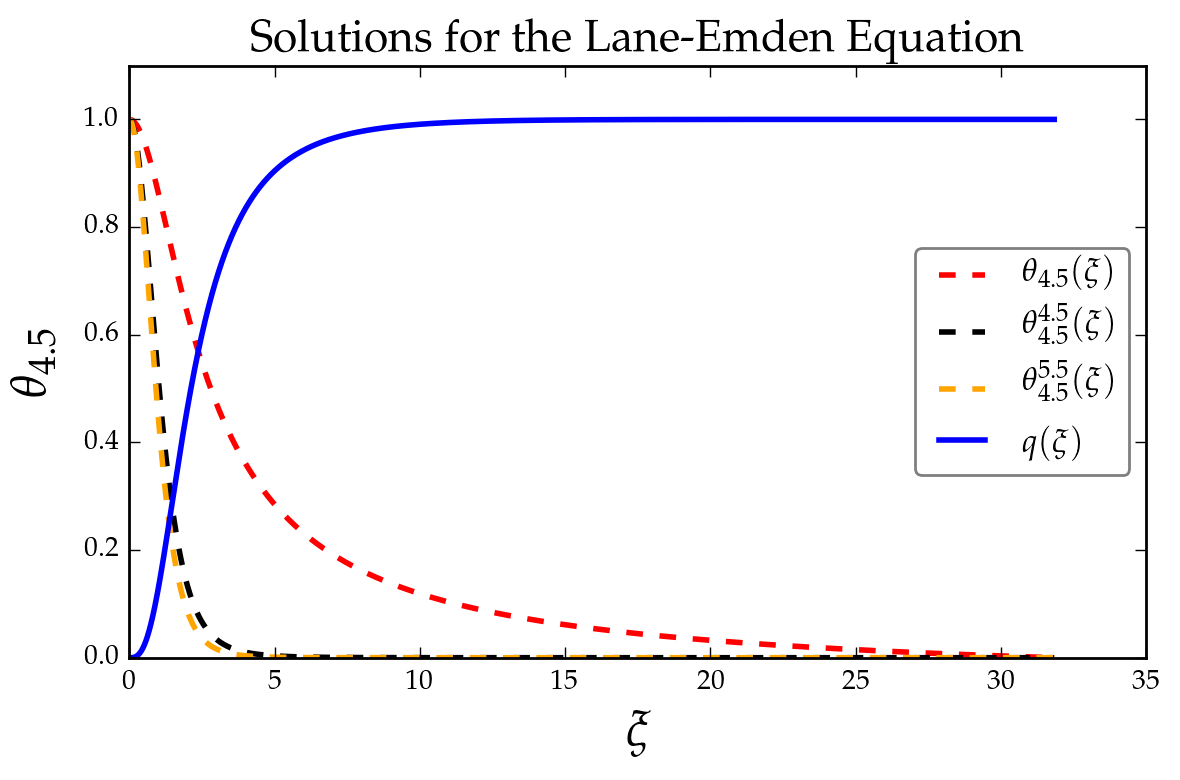

In [27]:
plt.figure(facecolor='white',dpi=200)
plt.title('Solutions for the Lane-Emden Equation', fontsize=16)
plt.xlabel(r'$\xi $', fontsize=18)
plt.ylabel(r'$\theta_{4.5}$', fontsize=18)
plt.plot(xi,y, linestyle='--', linewidth=2, color='red', label=r'$\theta_{4.5} (\xi)$')
plt.plot(xi,new_y,linestyle='--',color='black',linewidth=2, label = r'$\theta_{4.5}^{4.5} (\xi)$')
plt.plot(xi,new_y_5,linestyle='--',color='orange',linewidth=2, label = r'$\theta_{4.5}^{5.5} (\xi)$')
plt.plot(xi,qmass, linewidth=2,label = r'$q (\xi)$')
plt.ylim(0,1.1)
plt.legend(fancybox=True, framealpha=0.5, loc='center right')
plt.tight_layout()
plt.savefig('/Users/oanavesa/Desktop/GradSchool/Second_Year/ASTR565/ComputerProb10/Solutions_Lane_Emden.png')
plt.show()

In [42]:
# determining the values for part a)
print("The mean molecular weight is: ",(solar_mmw))
print("xi_1 is: ", surface_xi)
print("p_c/p is: ",central_density_average_density(surface_xi,surface_z,1,1))
print("W_n is:", W(4.5,surface_z))
print("N_n is: ", N(4.5,surface_xi,surface_z))
print("Theta_N is:", bigtheta(4.5,surface_xi,surface_z))
print("p_c is:",central_density(surface_xi,surface_z,Mass_cm,Rad_cm) )
print("P_c is:",central_pressure(4.5,surface_z,G_cm,Mass_cm,Rad_cm))
print("T_c is:", central_temperature(4.5,surface_xi,surface_z,Mass,Rad))

The mean molecular weight is:  0.6172839506172839
xi_1 is:  31.836464111056312
p_c/p is:  6189.473237287214
W_n is: 4921.842140612824
N_n is:  0.6579831993187846
Theta_N is: 3.3309077134227842
p_c is: 8728.384173893553
P_c is: 5.547725406522856e+19
T_c is: 47187760.8059032


In [43]:
# defining functions to determine the temperature and density grid for the temperature-density plot

def temperature_grid(n,xi_surf,z_surf,M,R,y_array):
    '''This solves for the overall temperature of the model.
    
    Input: 
    n = specific index
    xi_surf = the surface ξ_1 value
    z_surf = the surface (dθ/dξ_1) value
    M = mass
    R = radius
    y_array = θ_{4.5} array
    
    Output:
    temp = overall temperature '''
    temp = central_temperature(n,xi_surf,z_surf,M,R)*y_array
    return temp

def density_grid(xi_surf,z_surf,M,R,y_array_raised):
    ''' This solves for the overall density of the model.
    
    Input:
    xi_surf = the surface ξ_1 value
    z_surf = the surface (dθ/dξ_1) value
    M = mass
    R = radius
    y_array_raised = θ_{4.5}^{4.5} array
    
    Output:
    dens = overall density'''
    dens = central_density(xi_surf,z_surf,M,R)*y_array_raised
    return dens

In [45]:
# initializing the overall temperature and density

temp = temperature_grid(4.5,surface_xi,surface_z,Mass,Rad,np.array(y))
dens = (density_grid(surface_xi,surface_z,Mass,Rad,np.array(new_y)))

# Uploading the Solar Model Run from Computer Problem 0
h = mr.MesaData('/Users/oanavesa/Desktop/GradSchool/Second_Year/ASTR565/HW/HW1/tutorial/LOGS/history2.data')


/Users/oanavesa/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


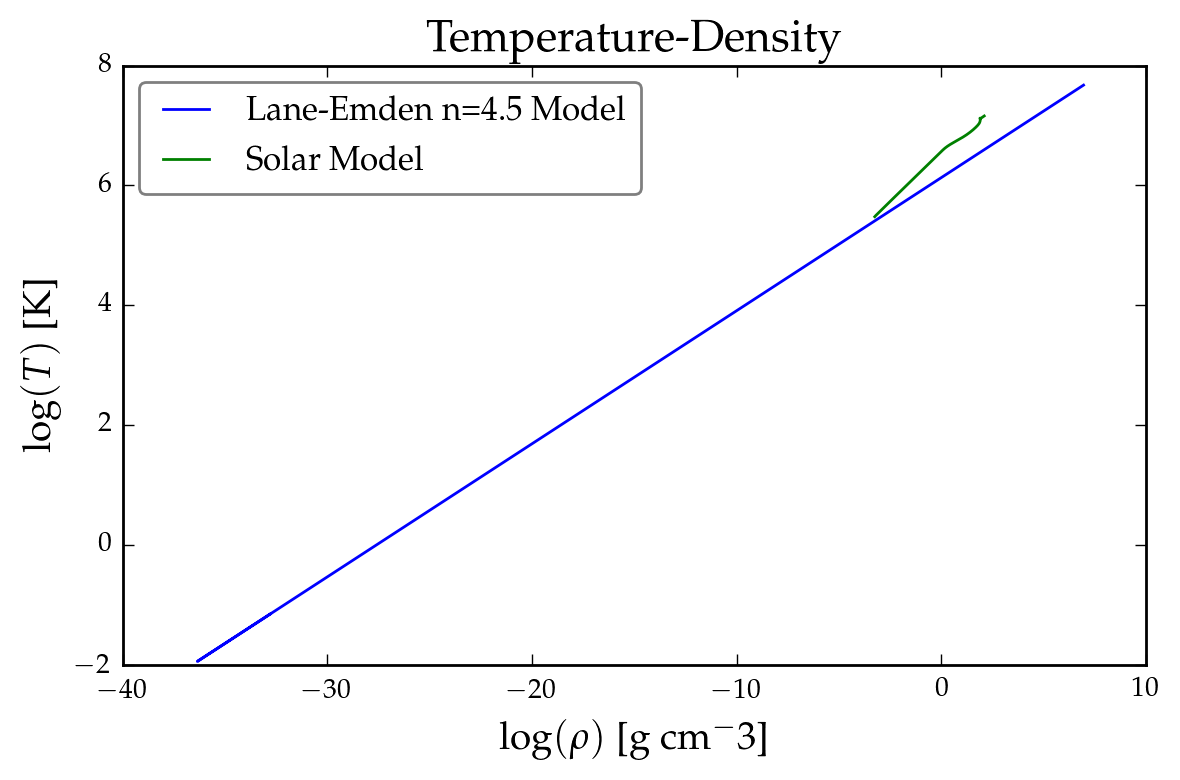

In [46]:
plt.figure(facecolor='white',dpi=200)
plt.title('Temperature-Density', fontsize=16)
plt.plot(np.log10(dens),np.log10(temp), label='Lane-Emden n=4.5 Model')
plt.ylabel(r'$\log (T)$ [K] ', fontsize=14)
plt.xlabel(r'$\log (\rho)$ [g cm$^-3$]', fontsize=14)
plt.plot(h.log_center_Rho, h.log_center_T, label='Solar Model')
plt.legend(loc='best',fancybox=True, framealpha=0.5)
plt.tight_layout()
plt.savefig('/Users/oanavesa/Desktop/GradSchool/Second_Year/ASTR565/ComputerProb10/temperature_density_space.png')
plt.show()